## Script de création de graphe
cf base de donnée CAIDA : https://publicdata.caida.org/datasets/as-relationships/serial-2/


**README :**
 
The as-rel file contain p2p and p2c relationships.
The format is:

`<provider-as>|<customer-as>|-1` <br>
`<peer-as>|<peer-as>|0|<source>`

    
Example : 
    
`1|11537|0|bgp` <br>
`1|21616|-1|bgp`

Le fichier contient environ 100 000 lignes de ce type

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import os
import pandas as pd
import networkx as nx
import pickle
os.popen("export DGLBACKEND=pytorch")
import dgl as dgl
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import arange

Using backend: pytorch


#### Définition diverses de fonction (utilisant du bash) permettant de vérifier que le graphe a été bien créé

In [2]:
# Fichier au choix parmi ceux de ./data/CAIDA_AS_RELATIONSHIP

#FILE_PATH='./data/CAIDA_AS_RELATIONSHIP/20200101.as-rel2.txt'
FILE_PATH='./data/CAIDA_AS_RELATIONSHIP/20210301.as-rel2.txt'

In [3]:
def encadre(message):
    print("\n****************************")
    print(message)
    print("****************************\n")

def nb_nodes_of_file(file):
    return int(os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq | wc -l" %file).read())
    
#def nb_edges_of_file(file):
#    return os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq | wc -l" %file).read()

def list_nodes_sorted(file):
    return os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq" %file).read()

def nb_peering_customer_provider(ASN):
    nb_peerings =  os.popen("cat %s | grep \"^%s|\||%s|\" | grep -v \".*\-1\" | wc -l" % (FILE_PATH, ASN, ASN)).read()
    nb_customers = os.popen("cat %s | grep \"^%s|.*\-1\" |wc -l " % (FILE_PATH, ASN)).read()
    nb_providers = os.popen("cat %s | grep \"|%s|\-1\" | wc -l" % (FILE_PATH, ASN)).read()
    return nb_peerings.split("\n")[0], nb_customers.split("\n")[0], nb_providers.split("\n")[0]

def csv_dataset(file):
    return os.popen()

In [4]:
nb_nodes_file = nb_nodes_of_file(FILE_PATH)
print("Nb nodes of file : " + str(nb_nodes_file))

Nb nodes of file : 71434


In [5]:
nb_type_links = nb_peering_customer_provider(4)
print("Link types and number (p2p, c, p) of node index 4 : " + str(nb_type_links))

Link types and number (p2p, c, p) of node index 4 : ('2', '1', '12')


### Panda Datasets

In [6]:
#AS_dataset_202001 = pd.read_csv('data/CAIDA_AS_CLASSIFICATION/20200101.as2types.txt', sep='|')
AS_dataset = pd.read_csv('data/CAIDA_AS_CLASSIFICATION/20210301.as2types.txt', sep='|')

### ATTENTION : si erreur, lancer le script `./sort_datasets.sh -h`

# Vérif nombre de noeuds
assert (len(AS_dataset.index) == nb_nodes_file)

In [7]:
AS_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71434 entries, 0 to 71433
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ASN           71434 non-null  int64 
 1   source_label  71434 non-null  object
 2   label         71434 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [8]:
print(AS_dataset["label"].value_counts())
print("\n")
print(AS_dataset["source_label"].value_counts())

Transit/Access    54367
Enterprise        13632
Content            3435
Name: label, dtype: int64


CAIDA_class     57895
peerDB_class    12889
manual_class      650
Name: source_label, dtype: int64


<AxesSubplot:>

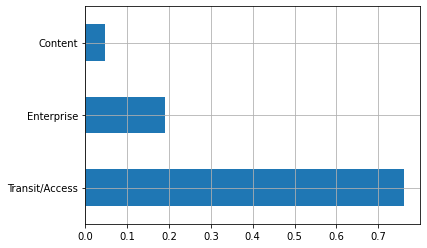

In [9]:
AS_dataset["label"].value_counts(normalize=True).plot(kind='barh', grid=True)

In [10]:
AS_dataset.head()

ASN source_label           label
0    1  CAIDA_class  Transit/Access
1    2  CAIDA_class  Transit/Access
2    3  CAIDA_class  Transit/Access
3    4  CAIDA_class  Transit/Access
4    5  CAIDA_class      Enterprise

In [11]:
def dictiongraph(fichier_texte):
    fichier = open(fichier_texte,"r")
    dictio = []
    memoire=-1
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            if asn1 != memoire:
                dictio.append(asn1)
                memoire = asn1
            dictio.append(asn2)
        except ValueError:
            pass
    l = arange(len(list(set(dictio))))
    dictiofinal =dict_from_list = dict(zip(sorted(list(set(dictio))), l))
    return dictiofinal

In [12]:
def creation_graph(fichier_texte):
    G = nx.Graph() 
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= str(asn1) + '|p2p|' +str(asn2))
            elif info == -1 :
                G.add_edge(dictio[asn1],dictio[asn2],type=str(asn1) + '|p2c|' +str(asn2))
        except ValueError:
            pass
    return G

In [13]:
G = creation_graph(FILE_PATH)

In [14]:
def creation_graph_dirige(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :

                G.add_edge(dictio[asn1],dictio[asn2],type= 3/3)
                
        except ValueError:
            pass
    return G

In [15]:
G_directed = creation_graph_dirige(FILE_PATH)

In [16]:
def creation_graph_dirige_inverse(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :

                G.add_edge(dictio[asn2],dictio[asn1],type= 3/3)
                
        except ValueError:
            pass
    return G

In [17]:
G_directed_inverse = creation_graph_dirige_inverse(FILE_PATH)

In [18]:
def label_into_int(label):
    if (label == 'Content'):
        int_label = 0
    elif (label == 'Transit/Access'):
        int_label = 1
    elif (label == 'Enterprise'):
        int_label = 2
    return int_label

In [19]:
def creation_graph_float(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,label=label_into_int(AS_dataset['label'][i]))
        #print("G add node : index " + str(i) + ", asn : " + str(num_as) + ", " + AS_dataset['label'][i] + " => " + str(label_into_int(AS_dataset['label'][i])))
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 3/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 1/3)
        except ValueError:
            pass
    return G

In [20]:
G_float =creation_graph_float(FILE_PATH)

In [21]:
def creation_graph_array(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,label=label_into_int(AS_dataset['label'][i]))
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= np.array([0,1,0]))
                G.add_edge(dictio[asn2],dictio[asn1],type= np.array([0,1,0]))
            elif info == -1 :
                G.add_edge(dictio[asn1],dictio[asn2],type=np.array([1,0,0]))
                G.add_edge(dictio[asn2],dictio[asn1],type=np.array([0,0,1]))
        except ValueError:
            pass
    return G

In [22]:
G_array=creation_graph_array(FILE_PATH)

In [23]:
nb_nodes_graph = G.number_of_nodes()
nb_edges_graph = G.number_of_edges()

print("Nb nodes du graphe : " + str(nb_nodes_graph))
print("Nb edges du graphe: " + str(nb_edges_graph))

assert(nb_nodes_graph == int(nb_nodes_of_file(FILE_PATH)))
print("\nASSERT NB NODES OK")

Nb nodes du graphe : 71434
Nb edges du graphe: 489716

ASSERT NB NODES OK


- ### Ajout des colonnes `page_rank_not_directed`, `page_rank_directed` et `degree_centrality`

In [24]:
list_pageRank = nx.pagerank(G).values()
list_pageRank_directed = nx.pagerank(G_directed).values()
list_pageRank_directed_inverse = nx.pagerank(G_directed_inverse).values()
list_degreeCentrality = nx.degree_centrality(G).values()

In [25]:
AS_dataset['page_rank_not_directed'] = list_pageRank
AS_dataset['page_rank_directed'] = list_pageRank_directed
AS_dataset['page_rank_directed_inverse'] = list_pageRank_directed_inverse
AS_dataset['degree_centrality'] = list_degreeCentrality

In [26]:
AS_dataset.head()

ASN source_label           label  page_rank_not_directed  \
0    1  CAIDA_class  Transit/Access                0.000025   
1    2  CAIDA_class  Transit/Access                0.000034   
2    3  CAIDA_class  Transit/Access                0.000031   
3    4  CAIDA_class  Transit/Access                0.000028   
4    5  CAIDA_class      Enterprise                0.000016   

   page_rank_directed  page_rank_directed_inverse  degree_centrality  
0            0.000082                    0.000017           0.000196  
1            0.000162                    0.000004           0.000294  
2            0.000067                    0.000092           0.000280  
3            0.000093                    0.000004           0.000210  
4            0.000126                    0.000004           0.000098

In [27]:
def dictiongraph_Nbnoeud_Asn(fichier_texte):
    fichier = open(fichier_texte,"r")
    dictio = []
    memoire=-1
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            if asn1 != memoire:
                dictio.append(asn1)
                memoire = asn1
            dictio.append(asn2)
        except ValueError:
            pass
    l = arange(len(list(set(dictio))))
    dictiofinal =dict_from_list = dict(zip(l, sorted(list(set(dictio)))))
    return dictiofinal
Dictio_noeud_as = dictiongraph_Nbnoeud_Asn(FILE_PATH)

In [ ]:
def nbtypevoisins2(G):
    nbNoeuds = G.number_of_nodes()
    Liste_Nb_Voisins_Peering = np.zeros(nbNoeuds)
    Liste_Nb_Voisins_Customer = np.zeros(nbNoeuds)
    Liste_Nb_Voisins_Provider = np.zeros(nbNoeuds)
    for i in range(nbNoeuds):
        for j in range(len(G[i])) :
            infos = list(G[i].values())[j]["type"].split("|")
            #print(infos)
            type_lien = infos[1]
            if type_lien == "p2p":

                Liste_Nb_Voisins_Peering[i] +=1
                #Liste_Nb_Voisins_Peering[dictio_as_noeud[int(asn2)]] +=1
            elif type_lien == "p2c":
                asn1 = infos[0]
                asn2 = infos[2]
                if int(asn2) == int(Dictio_noeud_as[i]) :
                     Liste_Nb_Voisins_Provider[i]+=1                
                else :
                    Liste_Nb_Voisins_Customer[i]+=1

        #print(i)

    return Liste_Nb_Voisins_Peering, Liste_Nb_Voisins_Customer, Liste_Nb_Voisins_Provider 
                
#### TEMPS D'EXECUTION : 5min ~
L1,L2,L3=nbtypevoisins2(G) 

- ### Vérification de la conformité des listes L1, L2 et L3 par rapport au graphe

In [69]:
max_degree_list = max(L1 + L2 + L3)
highest_degree_graph = max(list(dict(G.degree()).values()))
index_max = list(dict(G.degree()).values()).index(highest_degree_graph)
ASN_max = list(Dictio_noeud_as.values())[index_max]

print("Max degree list : " + str(max_degree_list))
print("Max degree index : " + str(index_max) + ", max degree ASN : " + str(ASN_max))
print("Max degree graph : " + str(highest_degree_graph))

assert (max_degree_list == highest_degree_graph)
print("\nASSERT MAX DEGREE OK")

Max degree list : 9083.0
Max degree index : 2475, max degree ASN : 6939
Max degree graph : 9083

ASSERT MAX DEGREE OK


In [70]:
# Extraction des maximum de p2p link, customer link et provider link
max_p2p, index_max_p2p = np.max(L1), np.argmax(L1)
max_c,   index_max_c   = np.max(L2), np.argmax(L2)
max_p,   index_max_p   = np.max(L3), np.argmax(L3)

print("Max p2p links          : " + str(max_p2p) + ", index : " + str(index_max_p2p) + ", ASN : " + str(list(Dictio_noeud_as.values())[index_max_p2p]))
print("Max nb customer links  : " + str(max_c)   + ", index : " + str(index_max_c)   + ", ASN : " + str(list(Dictio_noeud_as.values())[index_max_c]))
print("Max nb provider links  : " + str(max_p)   + ", index : " + str(index_max_p)   + ", ASN : " + str(list(Dictio_noeud_as.values())[index_max_p]))

Max p2p links          : 7250.0, index : 2475, ASN : 6939
Max nb customer links  : 6237.0, index : 107, ASN : 174
Max nb provider links  : 137.0, index : 11176, ASN : 20940


In [71]:
AS_dataset.iloc[index_max_p2p]

ASN                                     6939
source_label                    peerDB_class
label                         Transit/Access
page_rank_not_directed               0.00835
page_rank_directed                  0.009921
page_rank_directed_inverse          0.010811
degree_centrality                   0.127154
Name: 2475, dtype: object

In [72]:
AS_dataset.iloc[index_max_c]

ASN                                      174
source_label                    peerDB_class
label                         Transit/Access
page_rank_not_directed              0.010813
page_rank_directed                  0.000129
page_rank_directed_inverse          0.009297
degree_centrality                   0.088964
Name: 107, dtype: object

In [73]:
AS_dataset.iloc[index_max_p]

ASN                                  20940
source_label                  peerDB_class
label                              Content
page_rank_not_directed            0.000541
page_rank_directed                0.000361
page_rank_directed_inverse        0.000734
degree_centrality                 0.013271
Name: 11176, dtype: object

- ### Ajout des colonnes `peering_links`, `customer_links` et `provider_links`

In [74]:
AS_dataset['peering_links'] = L1/max_p2p
AS_dataset['customer_links'] = L2/max_c
AS_dataset['provider_links'] = L3/max_p

assert(AS_dataset['peering_links'][index_max_p2p] == 1)
assert(AS_dataset['customer_links'][index_max_c] == 1)
assert(AS_dataset['provider_links'][index_max_p] == 1)

In [75]:
AS_dataset.head()

ASN source_label           label  page_rank_not_directed  \
0    1  CAIDA_class  Transit/Access                0.000025   
1    2  CAIDA_class  Transit/Access                0.000034   
2    3  CAIDA_class  Transit/Access                0.000031   
3    4  CAIDA_class  Transit/Access                0.000028   
4    5  CAIDA_class      Enterprise                0.000016   

   page_rank_directed  page_rank_directed_inverse  degree_centrality  \
0            0.000082                    0.000017           0.000196   
1            0.000162                    0.000004           0.000294   
2            0.000067                    0.000092           0.000280   
3            0.000093                    0.000004           0.000210   
4            0.000126                    0.000004           0.000098   

   peering_links  customer_links  provider_links  
0       0.000276        0.000321        0.072993  
1       0.000138        0.000321        0.131387  
2       0.000690        0.000160        0.102190  
3       0.000276        0.000160        0.087591  
4       0.000276        0.000000        0.036496

- ### Ajout des colonnes `is_Content`, `is_Transit` et `is_Enterprise`

En effet, la colonne `label` est une **catégorie non ordinale**. Il faut donc la transformer en vecteur de valeur binaire, qui sera donné au GCN. <br> **On a alors :** <br><br>
dataset['is_Content'][i] = 1 ⇔ le noeud i du graphe est de type `Content` <br>
dataset['is_Transit'][i] = 1 ⇔ le noeud i du graphe est de type `Transit/Access` <br>
dataset['is_Enterprise'][i] = 1 ⇔ le noeud i du graphe est de type `Enterprise` <br>

In [76]:
AS_dataset['is_Content'] = (AS_dataset['label'] == 'Content').astype(int)
AS_dataset['is_Transit'] = (AS_dataset['label'] == 'Transit/Access').astype(int)
AS_dataset['is_Enterprise'] = (AS_dataset['label'] == 'Enterprise').astype(int)

In [77]:
AS_dataset.head()

ASN source_label           label  page_rank_not_directed  \
0    1  CAIDA_class  Transit/Access                0.000025   
1    2  CAIDA_class  Transit/Access                0.000034   
2    3  CAIDA_class  Transit/Access                0.000031   
3    4  CAIDA_class  Transit/Access                0.000028   
4    5  CAIDA_class      Enterprise                0.000016   

   page_rank_directed  page_rank_directed_inverse  degree_centrality  \
0            0.000082                    0.000017           0.000196   
1            0.000162                    0.000004           0.000294   
2            0.000067                    0.000092           0.000280   
3            0.000093                    0.000004           0.000210   
4            0.000126                    0.000004           0.000098   

   peering_links  customer_links  provider_links  is_Content  is_Transit  \
0       0.000276        0.000321        0.072993           0           1   
1       0.000138        0.000321        0.131387           0           1   
2       0.000690        0.000160        0.102190           0           1   
3       0.000276        0.000160        0.087591           0           1   
4       0.000276        0.000000        0.036496           0           0   

   is_Enterprise  
0              0  
1              0  
2              0  
3              0  
4              1

- ### Modification de la colonne `label`

On transforme la **catégorie non ordinale** en 3 classes entières :
 - *Content* ⇔ $0$
 - *Transit/Access* ⇔ $1$
 - *Enterprise* ⇔ $2$

In [78]:
AS_dataset['label'] = AS_dataset['label'].map({'Content': 0, 'Transit/Access': 1, 'Enterprise': 2})

In [79]:
AS_dataset.head()

ASN source_label  label  page_rank_not_directed  page_rank_directed  \
0    1  CAIDA_class      1                0.000025            0.000082   
1    2  CAIDA_class      1                0.000034            0.000162   
2    3  CAIDA_class      1                0.000031            0.000067   
3    4  CAIDA_class      1                0.000028            0.000093   
4    5  CAIDA_class      2                0.000016            0.000126   

   page_rank_directed_inverse  degree_centrality  peering_links  \
0                    0.000017           0.000196       0.000276   
1                    0.000004           0.000294       0.000138   
2                    0.000092           0.000280       0.000690   
3                    0.000004           0.000210       0.000276   
4                    0.000004           0.000098       0.000276   

   customer_links  provider_links  is_Content  is_Transit  is_Enterprise  
0        0.000321        0.072993           0           1              0  
1        0.000321        0.131387           0           1              0  
2        0.000160        0.102190           0           1              0  
3        0.000160        0.087591           0           1              0  
4        0.000000        0.036496           0           0              1

#### TO DO :
- Afficher les n noeuds de plus haut degré du graphe G, avec les infos du ASN correspondant (en utilisant l'API de CAIDA)
- Trouver d'autres visualisations de ce jeu de donnée qui le caractérisent.

### Exportation des données : `dataset` et `graph`

On crée 4 fichiers : 
- Le `dataset`complet 
- Le `graphe` nx au format pickle
- Le `graphe_float` nx au format pickle
- Le `graphe_array` nx au format pickle

In [80]:
# Exportation des données

suffix = FILE_PATH.split('/')[3].split('.')[0]

AS_dataset.to_csv('data_GCN/dataset_'+suffix+'.csv', index=False)
nx.write_gpickle(G, 'data_GCN/graph_'+suffix+'.pickle')
nx.write_gpickle(G_float, 'data_GCN/graph_float_'+suffix+'.pickle')
nx.write_gpickle(G_array, 'data_GCN/graph_array_'+suffix+'.pickle')